# Part-of-Speech Tagging using Feedforward Networks and Embeddings
Author: Pierre Nugues

A part-of-speech tagger using feed-forward networks and GloVe embeddings and trained on a corpus following the Universal Dependencies format. Here we use the English Web Treebank:
https://github.com/UniversalDependencies/UD_English-EWT/tree/master.

## Python Headers

### The Modules

In [1]:
import sys
import os
from sklearn.feature_extraction import DictVectorizer
import time
from keras import models
from keras.layers import LSTM, Bidirectional, SimpleRNN, Dense, Embedding, Flatten
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import load_model
import math
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

### Some Parameters

In [2]:
OPTIMIZER = 'rmsprop'
BATCH_SIZE = 128
EPOCHS = 8
MINI_CORPUS = False
EMBEDDING_DIM = 100
W_SIZE = 2

## Preprocessing

### Loading the Embeddings
We will use GloVe embeddings and load them

In [3]:
def load(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    file = file
    embeddings = {}
    glove = open(file)
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:])
        embeddings[word] = vector
    glove.close()
    embeddings_dict = embeddings
    embedded_words = sorted(list(embeddings_dict.keys()))
    return embeddings_dict

In [4]:
embedding_file = '/Users/pierre/Documents/Cours/EDAN20/corpus/glove.6B.100d.txt'
embeddings_dict = load(embedding_file)

In [5]:
embeddings_dict['table']

array(['-0.61454', '0.89693', '0.56771', '0.39102', '-0.22437', '0.49035',
       '0.10868', '0.27411', '-0.23833', '-0.52153', '0.73551',
       '-0.32654', '0.51304', '0.32415', '-0.46709', '0.68051',
       '-0.25497', '-0.040484', '-0.54418', '-1.0548', '-0.46692',
       '0.23557', '0.31234', '-0.34537', '0.14793', '-0.53745',
       '-0.43215', '-0.48724', '-0.51019', '-0.9051', '-0.17919',
       '-0.018376', '0.09719', '-0.31623', '0.7512', '0.92236',
       '-0.49965', '0.14036', '-0.28296', '-0.97443', '-0.0094408',
       '-0.62944', '0.14711', '-0.94376', '0.0075222', '0.18565',
       '-0.99172', '0.072789', '-0.18474', '-0.52901', '0.38995',
       '-0.45677', '-0.21932', '1.3723', '-0.29636', '-2.2342',
       '-0.36667', '0.04987', '0.63421', '0.53275', '-0.53955', '0.31398',
       '-0.44698', '-0.38389', '0.066668', '-0.02168', '0.20558',
       '0.59456', '-0.24892', '-0.52795', '-0.3761', '0.077104',
       '0.75222', '-0.2647', '-0.0587', '0.67541', '-0.16559', '-0

### Loading the Corpus

In [6]:
def load_ud_en_ewt():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/ud-treebanks-v2.8/UD_English-EWT/'
    train_file = BASE_DIR + 'en_ewt-ud-train.conllu'
    dev_file = BASE_DIR + 'en_ewt-ud-dev.conllu'
    test_file = BASE_DIR + 'en_ewt-ud-test.conllu'
    column_names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 
                    'FEATS', 'HEAD', 'DEPREL', 'HEAD', 'DEPS', 'MISC']
    column_names = list(map(str.lower, column_names))
    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

def load_conll2009_pos():
    BASE_DIR = '/Users/pierre/Documents/Cours/EDAN20/corpus/conll2009/en/'
    train_file = BASE_DIR + 'CoNLL2009-ST-English-train-pos.txt'
    dev_file = BASE_DIR + 'CoNLL2009-ST-English-development-pos.txt'
    test_file = BASE_DIR + 'CoNLL2009-ST-test-words-pos.txt'
    # test2_file = 'simple_pos_test.txt'

    column_names = ['id', 'form', 'lemma', 'plemma', 'pos', 'ppos']

    train_sentences = open(train_file).read().strip()
    dev_sentences = open(dev_file).read().strip()
    test_sentences = open(test_file).read().strip()
    # test2_sentences = open(test2_file).read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

# train_sentences, dev_sentences, test_sentences, column_names = \
# load_conll2009_pos()
train_sentences, dev_sentences, test_sentences, column_names =\
load_ud_en_ewt()
train_sentences[:100]

'# newdoc id = weblog-juancole.com_juancole_20051126063000_ENG_20051126_063000\n# sent_id = weblog-jua'

### Converting the Corpus in a Dictionary
We follow the fit-transform pattern of sklearn

In [7]:
import regex as re

class Token(dict):
    pass

class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        rows = [row for row in rows if row[0] != '#']
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [8]:
conll_dict = CoNLLDictorizer(column_names, col_sep='\t')

train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

if MINI_CORPUS:
    train_dict = train_dict[:len(train_dict) // 5]
print('First sentence, train:', train_dict[0])

First sentence, train: [{'id': '1', 'form': 'Al', 'lemma': 'Al', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '0:root', 'deprel': 'root', 'deps': 'SpaceAfter=No'}, {'id': '2', 'form': '-', 'lemma': '-', 'upos': 'PUNCT', 'xpos': 'HYPH', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': 'SpaceAfter=No'}, {'id': '3', 'form': 'Zaman', 'lemma': 'Zaman', 'upos': 'PROPN', 'xpos': 'NNP', 'feats': 'Number=Sing', 'head': '1:flat', 'deprel': 'flat', 'deps': '_'}, {'id': '4', 'form': ':', 'lemma': ':', 'upos': 'PUNCT', 'xpos': ':', 'feats': '_', 'head': '1:punct', 'deprel': 'punct', 'deps': '_'}, {'id': '5', 'form': 'American', 'lemma': 'American', 'upos': 'ADJ', 'xpos': 'JJ', 'feats': 'Degree=Pos', 'head': '6:amod', 'deprel': 'amod', 'deps': '_'}, {'id': '6', 'form': 'forces', 'lemma': 'force', 'upos': 'NOUN', 'xpos': 'NNS', 'feats': 'Number=Plur', 'head': '7:nsubj', 'deprel': 'nsubj', 'deps': '_'}, {'id': '7', 'form': 'killed', 'lemma': 'kill', 'upos': 'VERB', 'xpos'

### Extracting the Context and Dictorizing it

In [9]:
class ContextDictorizer():
    """
    Extract contexts of words in a sequence
    Contexts are of w_size to the left and to the right
    Builds an X matrix in the form of a dictionary
    and possibly extracts the output, y, if not in the test step
    If the test_step is True, returns y = []
    """

    def __init__(self, input='form', output='upos', w_size=2, tolower=True):
        self.BOS_symbol = '__BOS__'
        self.EOS_symbol = '__EOS__'
        self.input = input
        self.output = output
        self.w_size = w_size
        self.tolower = tolower
        # This was not correct as the names were not sorted
        # self.feature_names = [input + '_' + str(i)
        #                     for i in range(-w_size, w_size + 1)]
        # To be sure the names are ordered
        zeros = math.ceil(math.log10(2 * w_size + 1))
        self.feature_names = [input + '_' + str(i).zfill(zeros) for 
                              i in range(2 * w_size + 1)]

    def fit(self, sentences):
        """
        Build the padding rows
        :param sentences:
        :return:
        """
        self.column_names = sentences[0][0].keys()
        start = [self.BOS_symbol] * len(self.column_names)
        end = [self.EOS_symbol] * len(self.column_names)
        start_token = Token(dict(zip(self.column_names, start)))
        end_token = Token(dict(zip(self.column_names, end)))
        self.start_rows = [start_token] * self.w_size
        self.end_rows = [end_token] * self.w_size

    def transform(self, sentences, training_step=True):
        X_corpus = []
        y_corpus = []
        for sentence in sentences:
            X, y = self._transform_sentence(sentence, training_step)
            X_corpus += X
            if training_step:
                y_corpus += y
        return X_corpus, y_corpus

    def fit_transform(self, sentences):
        self.fit(sentences)
        return self.transform(sentences)

    def _transform_sentence(self, sentence, training_step=True):
        # We extract y
        if training_step:
            y = [row[self.output] for row in sentence]
        else:
            y = None

        # We pad the sentence
        sentence = self.start_rows + sentence + self.end_rows

        # We extract the features
        X = list()
        for i in range(len(sentence) - 2 * self.w_size):
            # x is a row of X
            x = list()
            # The words in lower case
            for j in range(2 * self.w_size + 1):
                if self.tolower:
                    x.append(sentence[i + j][self.input].lower())
                else:
                    x.append(sentence[i + j][self.input])
            # We represent the feature vector as a dictionary
            X.append(dict(zip(self.feature_names, x)))
        return X, y

    def print_example(self, sentences, id=1968):
        """
        :param corpus:
        :param id:
        :return:
        """
        # We print the features to check they match Table 8.1 in my book (second edition)
        # We use the training step extraction with the dynamic features
        Xs, ys = self._transform_sentence(sentences[id])
        print('X for sentence #', id, Xs)
        print('y for sentence #', id, ys)

### Running the Feature Extraction

In [10]:
context_dictorizer = ContextDictorizer()
context_dictorizer.fit(train_dict)
X_train_dict, y_train_cat = context_dictorizer.transform(train_dict)
X_val_dict, y_val_cat = context_dictorizer.transform(dev_dict)

In [11]:
context_dictorizer.print_example(train_dict)

X for sentence # 1968 [{'form_0': '__bos__', 'form_1': '__bos__', 'form_2': 'do', 'form_3': 'we', 'form_4': 'intend'}, {'form_0': '__bos__', 'form_1': 'do', 'form_2': 'we', 'form_3': 'intend', 'form_4': 'to'}, {'form_0': 'do', 'form_1': 'we', 'form_2': 'intend', 'form_3': 'to', 'form_4': 'reference'}, {'form_0': 'we', 'form_1': 'intend', 'form_2': 'to', 'form_3': 'reference', 'form_4': 'a'}, {'form_0': 'intend', 'form_1': 'to', 'form_2': 'reference', 'form_3': 'a', 'form_4': 'particular'}, {'form_0': 'to', 'form_1': 'reference', 'form_2': 'a', 'form_3': 'particular', 'form_4': 'manufacturer'}, {'form_0': 'reference', 'form_1': 'a', 'form_2': 'particular', 'form_3': 'manufacturer', 'form_4': ','}, {'form_0': 'a', 'form_1': 'particular', 'form_2': 'manufacturer', 'form_3': ',', 'form_4': 'or'}, {'form_0': 'particular', 'form_1': 'manufacturer', 'form_2': ',', 'form_3': 'or', 'form_4': 'should'}, {'form_0': 'manufacturer', 'form_1': ',', 'form_2': 'or', 'form_3': 'should', 'form_4': 'this

### We extract all the words

In [12]:
corpus_words = []
for x in X_train_dict:
    corpus_words.extend(x.values())
corpus_words = sorted(set(corpus_words))
print('# unique words seen in training corpus:', len(corpus_words))

# unique words seen in training corpus: 17113


### We add these words to the vocabulary
We add one word to the count for the unknown words

In [13]:
embeddings_words = embeddings_dict.keys()
print('Words in GloVe:',  len(embeddings_dict.keys()))
vocabulary_words = set(corpus_words + list(embeddings_words))
cnt_uniq = len(vocabulary_words) + 1
print('# unique words in the vocabulary: embeddings and corpus:', 
      cnt_uniq)

Words in GloVe: 400000
# unique words in the vocabulary: embeddings and corpus: 402010


### We now build an index
We keep index 0 for the unknown words

In [14]:
idx_word = dict(enumerate(sorted(vocabulary_words), start=1))
word_idx = {v: k for k, v in idx_word.items()}

### We replace the words with their index

In [15]:
for x_train_dict in X_train_dict:
    for word in x_train_dict:
        x_train_dict[word] = word_idx[x_train_dict[word]]

for x_val_dict in X_val_dict:
    for word in x_val_dict:
        x_val_dict[word] = word_idx.get(x_val_dict[word], 0)

In [16]:
dict_vect = DictVectorizer(sparse=False)
X_train = dict_vect.fit_transform(X_train_dict)
X_val = dict_vect.transform(X_val_dict)

In [17]:
X_train.shape

(207224, 5)

In [18]:
X_train[0]

array([ 43516.,  43516.,  50470.,    653., 397775.])

### And $\mathbf{y}$

In [19]:
# The POS and the number of different POS
pos_list = sorted(list(set(y_train_cat)))
NB_CLASSES = len(pos_list) + 1

In [20]:
# We build a part-of-speech index. We keep 0 for unknown symbols in the test set
idx_pos = dict(enumerate(pos_list, start=1))
pos_idx = {v: k for k, v in idx_pos.items()}

# We encode y
y_train = np.array([pos_idx[i] for i in y_train_cat])
y_val = np.array([pos_idx[i] for i in y_val_cat])

In [21]:
y_train_cat[:10]

['PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'ADJ',
 'NOUN',
 'VERB',
 'PROPN',
 'PROPN',
 'PROPN']

In [22]:
y_train[:10]

array([12, 13, 12, 13,  1,  8, 16, 12, 12, 12])

### We now create the matrix

In [23]:
embedding_matrix = np.random.random((len(vocabulary_words) + 1, 
                                     EMBEDDING_DIM))

In [24]:
for word in vocabulary_words:
    if word in embeddings_dict:
        # If the words are in the embeddings, we fill them with a value
        embedding_matrix[word_idx[word]] = embeddings_dict[word]

In [25]:
from tensorflow.keras import initializers

model = models.Sequential([
    Embedding(cnt_uniq, 
              EMBEDDING_DIM,
              trainable=True,
              embeddings_initializer=initializers.Constant(embedding_matrix),
              input_length=2 * W_SIZE + 1),
    Flatten(),
    Dense(NB_CLASSES, activation='softmax')
])

#model.layers[0].trainable = True

2021-11-19 13:23:32.453891: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=OPTIMIZER,
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 100)            40201000  
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 19)                9519      
                                                                 
Total params: 40,210,519
Trainable params: 40,210,519
Non-trainable params: 0
_________________________________________________________________


We use a callback to store our best model using the validation loss

In [28]:
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint('simple_embeddings.keras',
                                   save_best_only=True)
]

In [29]:
history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), 
                    batch_size=BATCH_SIZE)

Epoch 1/8
1619/1619 [==============================] - 214s 132ms/step - loss: 0.5388 - accuracy: 0.8430 - val_loss: 0.3254 - val_accuracy: 0.9010
Epoch 2/8
1619/1619 [==============================] - 216s 134ms/step - loss: 0.2287 - accuracy: 0.9290 - val_loss: 0.2739 - val_accuracy: 0.9172
Epoch 3/8
1619/1619 [==============================] - 218s 135ms/step - loss: 0.1836 - accuracy: 0.9430 - val_loss: 0.2632 - val_accuracy: 0.9215
Epoch 4/8
1619/1619 [==============================] - 219s 135ms/step - loss: 0.1604 - accuracy: 0.9505 - val_loss: 0.2566 - val_accuracy: 0.9243
Epoch 5/8
1619/1619 [==============================] - 221s 137ms/step - loss: 0.1444 - accuracy: 0.9559 - val_loss: 0.2538 - val_accuracy: 0.9230
Epoch 6/8
1619/1619 [==============================] - 223s 138ms/step - loss: 0.1323 - accuracy: 0.9599 - val_loss: 0.2533 - val_accuracy: 0.9246
Epoch 7/8
1619/1619 [==============================] - 221s 136ms/step - loss: 0.1222 - accuracy: 0.9633 - val_loss: 0

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

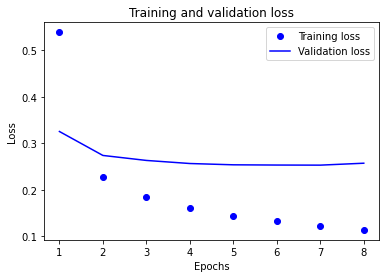

In [31]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

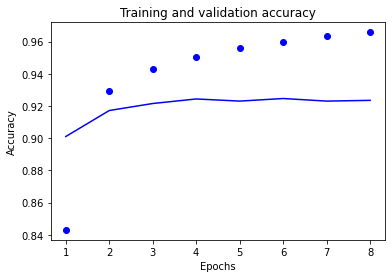

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

We load our best model

In [33]:
model = keras.models.load_model('simple_embeddings.keras')

### Testing the Model

In [34]:
X_test_dict, y_test_cat = context_dictorizer.transform(test_dict)
for x_test_dict in X_test_dict:
    for word in x_test_dict:
        x_test_dict[word] = word_idx.get(x_test_dict[word], 0)
            
# We transform the symbols into numbers
X_test = dict_vect.transform(X_test_dict)
y_test = np.array([pos_idx.get(i, 0) for i in y_test_cat])

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Optimizer', OPTIMIZER, 'Epochs', EPOCHS, 'Batch size', 
      BATCH_SIZE, 'Mini corpus', MINI_CORPUS)
print('Loss:', test_loss)
print('Accuracy:', test_acc)

796/796 [==============================] - 1s 683us/step - loss: 0.2433 - accuracy: 0.9261
Optimizer rmsprop Epochs 8 Batch size 128 Mini corpus False
Loss: 0.24327071011066437
Accuracy: 0.9261049032211304


About 92.29 for a simple logistic regression

## Prediction of parts of speech

In [35]:
def predict_sentence(sentence, dict_vect, model, word_idx, idx_pos):
    column_names = ['id', 'form']
    sentence = list(enumerate(sentence.lower().split(), start=1))
    conll_cols = ''
    for tuple in sentence:
        conll_cols += str(tuple[0]) + '\t' + tuple[1] + '\n'
    # print(conll_cols)

    conll_dict = CoNLLDictorizer(column_names, col_sep='\t')
    sent_dict = conll_dict.transform(conll_cols)
    # print('Sentence:', sent_dict[0])

    context_dictorizer = ContextDictorizer()
    context_dictorizer.fit(sent_dict)
    X_dict, y = context_dictorizer.transform(sent_dict, 
                                             training_step=False)
    # print('Sentence, padded:', X_dict)
    # print('POS, y:', y)

    for x_dict in X_dict:
        for word in x_dict:
            x_dict[word] = word_idx.get(x_dict[word], 1)
    X = dict_vect.transform(X_dict)

    # print(X)
    y_prob = model.predict(X)
    y_pred = y_prob.argmax(axis=-1)
    y_pred_cat = list(map(idx_pos.get, y_pred))
    return y_pred_cat

In [36]:
sentences = ["That round table might collapse .",
                 "The man can learn well .",
                 "The man can swim .",
                 "The man can simwo ."]
for sentence in sentences:
    y_test_cat_pred = predict_sentence(sentence.lower(), 
                                       dict_vect,
                                       model, word_idx, 
                                       idx_pos)
    print(sentence)
    print(y_test_cat_pred)

That round table might collapse .
['DET', 'NOUN', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can learn well .
['DET', 'NOUN', 'AUX', 'VERB', 'ADV', 'PUNCT']
The man can swim .
['DET', 'NOUN', 'AUX', 'VERB', 'PUNCT']
The man can simwo .
['DET', 'NOUN', 'AUX', 'PUNCT', 'PUNCT']
